# 01 Loading our custom made functions file

In [ ]:
import importlib
import functions
import spectrogram_plotting_functions

importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

## 02 Loading the folder that contains our data

In [ ]:
import glob
import getpass
user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat_filtered\\*.mat')
savepath = base+'\\results\\'
print(files)

In [ ]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

## 03  Looping through all the data files

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import pickle

#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230626_dk5_BW_nocontext_day1.mat'] #This is just for testing purposes
events_codes_all = {}
compiled_data_all_epochs = pd.DataFrame()

for file in files:
    # Initialize an empty DataFrame to store the results for all epochs
    ## Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)

    date, mouse_id, task=functions.exp_params(base_name)
    print(date, mouse_id, task)
    if task == 'nocontextday2' or task == 'nocontextos2':
        task = 'nocontext'
    if task =='nocontext':
        continue
    ## Open the file
    f=h5py.File(file, 'r')
    channels = list(f.keys())
    print(channels)
    if not any("AON" in channel or "vHp" in channel for channel in channels):
        continue
    events,reference_electrode=functions.get_keyboard_and_ref_channels(f,channels)
    
    #Generating epochs from events (epochs are basically start of a trial and end of a trial)
    events_codes=np.array(events['codes'][0])
    events_times=np.array(events['times'][0])
    events_codes_all[base_name] = events_codes
    epochs=functions.generate_epochs_with_first_event(events_codes, events_times)

    # Experiment Start time
    first_event=events_times[0]

    #finding global start and end time of all channels, since they start and end recordings at different times
    global_start_time, global_end_time=functions.find_global_start_end_times(f,channels)
    
    ## Reference electrode finding and padding
    reference_time = np.array(reference_electrode['times']).flatten()
    reference_value = np.array(reference_electrode['values']).flatten()
    padd_ref_data,padded_ref_time=functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)

    for channeli in channels:
        if "AON" in channeli or  "vHp" in channeli or 'Ref' in channeli:
            
            channel_id=channeli
            # Extracting raw data and time
            data_all=f[channeli]
            raw_data=np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()
            sampling_rate = int(1/data_all['interval'][0][0])
            print(raw_data.shape, raw_time.shape, sampling_rate)
            
            padded_data,padded_time=functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
            if channel_id=='Ref':
                subtracted_data=padded_data
            else:
                subtracted_data=padded_data-padd_ref_data
            
            notch_filtered_data=functions.iir_notch(subtracted_data, sampling_rate,60)

            # Normalizing the data by subtracting the mean and std of data 30sec before the first event
            #normalized_data,time,data_before=functions.data_normalization(raw_data,raw_time,first_event, sampling_rate)
            data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
            
            
            normalized_data=notch_filtered_data
            #normalized_data=functions.zscore_event_data(notch_filtered_data, baseline_mean, baseline_std)
            # Applying a notch filter
            total=normalized_data
            # Extracting the bands
            beta=functions.beta_band(normalized_data, sampling_rate)
            gamma=functions.gamma_band(normalized_data, sampling_rate)
            theta=functions.theta_band(normalized_data, sampling_rate)

            all_bands=[total,beta, gamma, theta]

            for i,epochi in enumerate(epochs):
                compiled_data = pd.DataFrame()

                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                print(dig_type)
                dig_timestamp = epochi[1, 0]
                print(door_timestamp,trial_type,dig_timestamp,dig_type)
                for bandi in all_bands:
                    data_complete_trial=functions.extract_complete_trial_data(bandi,time,door_timestamp,dig_timestamp,sampling_rate)
                    data_trial_before, data_trial_after=functions.extract_door_data(bandi,time,door_timestamp,sampling_rate)
                    data_dig_before, data_dig_after=functions.extract_dig_data(bandi,time,dig_timestamp,sampling_rate)

                                        # Create a DataFrame for the current bandi
                    bandi_data = pd.DataFrame({
                        'data_complete_trial': [data_complete_trial],
                        'data_trial_before': [data_trial_before],
                        'data_trial_after': [data_trial_after],
                        'data_dig_before': [data_dig_before],
                        'data_dig_after': [data_dig_after]
                    })
                    
                    # Concatenate the current bandi DataFrame with the compiled_data DataFrame along axis=1
                    compiled_data = pd.concat([compiled_data, bandi_data], axis=1)
                compiled_data.columns = ['total_complete_trial','total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
                            'beta_complete_trial','beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
                            'gamma_complete_trial','gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
                            'theta_complete_trial','theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']
                compiled_data.insert(0, 'rat', mouse_id)
                compiled_data.insert(1, 'date', date)
                compiled_data.insert(2, 'experiment', task)
                compiled_data.insert(3, 'channel', channel_id)
                compiled_data.insert(4, 'trial', i)
                compiled_data.insert(5, 'timestamps', [[door_timestamp, dig_timestamp]])

                compiled_data.insert(6, 'side', keyboard_dict[str(int(trial_type))])
                compiled_data.insert(7, 'correct?', keyboard_dict[str(int(dig_type))])
                compiled_data.insert(8, 'first 30 seconds power', functions.calculate_power_1D(data_before))
                compiled_data.insert(9, 'time', [time])
                
                compiled_data_all_epochs = pd.concat([compiled_data_all_epochs, compiled_data], axis=0, ignore_index=True)
    
    #spectrogram_plotting_functions.spectrogram_ind_trial(compiled_data_all_epochs, mouse_id, task, sampling_rate, savepath, base_name)

    #compiled_data_all_epochs.to_csv(f'{base_name}_compiled_data.csv', index=False)
    # with open(os.path.join(savepath, f'{base_name}_compiled_data.pkl'), 'wb') as file:
    #     pickle.dump(compiled_data_all_epochs, file)
                # Extracting data around events

    #
             
    # data_around_events=functions.data_events_extract(notch_filtered_data,time,epochs,sampling_rate)

    #         beta_around_events=functions.data_events_extract(beta,time,epochs,sampling_rate)
    #         gamma_around_events=functions.data_events_extract(gamma,time,epochs,sampling_rate)
    #         theta_around_events=functions.data_events_extract(theta,time,epochs,sampling_rate)

    #         # Creating a dataframe
    #         new_row=pd.DataFrame({'experiment_id':base_name,'channel_id':channel_id,
    #                             'epochs':[epochs],'first_event':[first_event],
    #                             'data_around_events':[data_around_events],
    #                             'beta_around_events':[beta_around_events],
    #                             'gamma_around_events':[gamma_around_events],
    #                             'theta_around_events':[theta_around_events]})
    #         try:
    #             compiled_data=pd.concat([compiled_data,new_row],ignore_index=True)
    #         except Exception as e:
    #             print(e)
    #     import pickle

    # #Save the DataFrame to a pickle file
    # with open(f'{base_name}_compiled_data.pkl', 'wb') as file:
    #     pickle.dump(compiled_data, file)

In [ ]:
(compiled_data_all_epochs.shape)
compiled_data_all_epochs['unique_id'] = compiled_data_all_epochs['rat'] + '_' + compiled_data_all_epochs['date'] + '_' + compiled_data_all_epochs['experiment']


## 4.1 Here we plot spectrogram of a single trial

Most intense frequencies (Hz): 19.53125


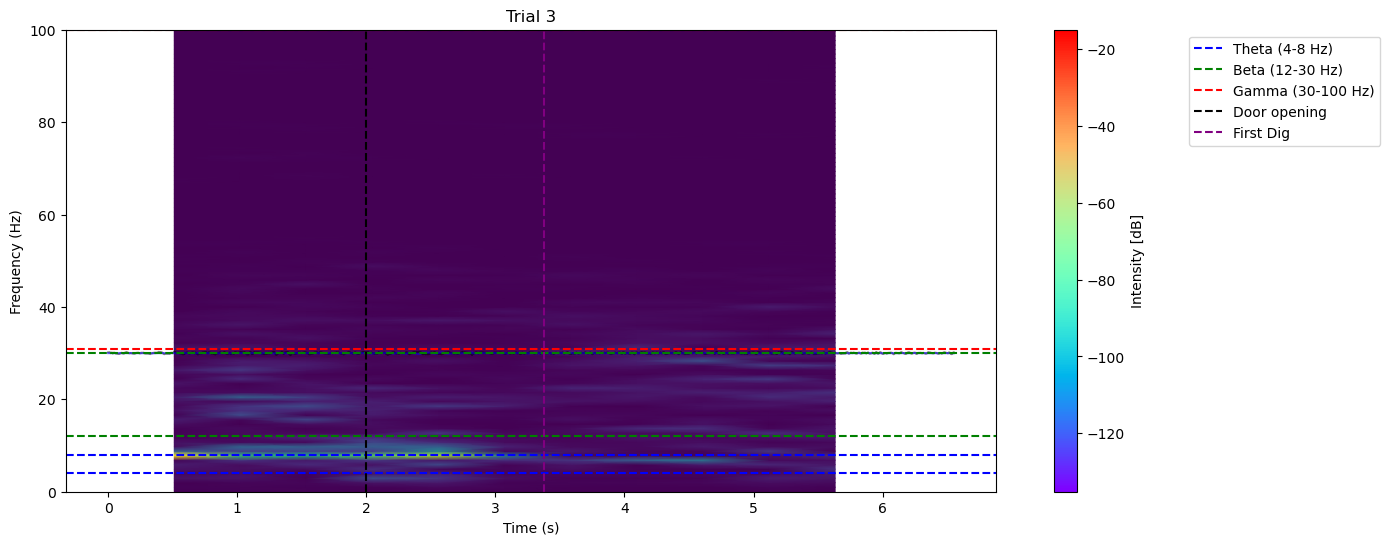

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
# Use the inline backend to display plots within the notebook
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))  # Increase the width of the figure

# Generate the spectrogram
i = 3

# Plot the spectrogram with increased number of bins
#fig, ax = plt.subplots(figsize=(15, 6))  # Increase the width of the
f,t,Sxx= scipy.signal.spectrogram(compiled_data_all_epochs.iloc[i]['total_complete_trial'], fs=sampling_rate, nperseg=2048, noverlap=1024)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
#Pxx, freqs, bins, im = ax.specgram(compiled_data_all_epochs.iloc[i]['total_complete_trial'], Fs=sampling_rate, cmap="rainbow", NFFT=2048, noverlap=1024)  # Increase the number of bins
time=np.linspace(0, len(compiled_data_all_epochs.iloc[i]['total_complete_trial'])/sampling_rate, len(compiled_data_all_epochs.iloc[i]['total_complete_trial']))
data=compiled_data_all_epochs.iloc[i]['total_complete_trial']
ref=compiled_data_all_epochs.loc[compiled_data_all_epochs['channel']=='Ref'].iloc[i]['total_complete_trial']
# Plot the raw data
ax.plot(time, data+30, color='black', alpha=0.5)
ax.plot(time, ref+30, color='blue', alpha=0.5)

# Find the maximum intensity for each frequency bin
max_intensity_indices = np.argmax(Pxx, axis=1)
max_intensities = Pxx[np.arange(Pxx.shape[0]), max_intensity_indices]

# Find the corresponding frequencies
most_intense_frequencies = freqs[np.argmax(max_intensities)]

# Print the most intense frequencies
print("Most intense frequencies (Hz):", most_intense_frequencies)

ax.set_title('Trial {}'.format(i))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_ylim(0, 100)
# ax.set_yscale('log')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensity [dB]')

# Plot horizontal bands for theta, beta, and gamma oscillations
ax.axhline(y=4, color='blue', linestyle='--', label='Theta (4-8 Hz)')
ax.axhline(y=8, color='blue', linestyle='--')
ax.axhline(y=12, color='green', linestyle='--', label='Beta (12-30 Hz)')
ax.axhline(y=30, color='green', linestyle='--')
ax.axhline(y=31, color='red', linestyle='--', label='Gamma (30-100 Hz)')
ax.axhline(y=100, color='red', linestyle='--')

# Plot vertical lines at 2 seconds after the start and 2 seconds before the end
# start_time = bins[0]
# end_time = bins[-1]
ax.axvline(x=2, color='black', linestyle='--', label='Door opening', ymin=0, ymax=1)
ax.axvline(x=end_time - 2, color='purple', linestyle='--', label='First Dig', ymin=0, ymax=1)

# Add a legend outside of the main plot
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper left')

# Display the plot
plt.show()

## 4.2 here we plot spectrograms of the four events of interest.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
total_bands=['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor']

fig, axs=plt.subplots(2,2)
axs=axs.flatten()
for i,bandi in enumerate(total_bands):
    ax=axs[i]
    
    # Generate the spectrogram
    Pxx, freqs, bins, im = ax.specgram(compiled_data[bandi][0], Fs=sampling_rate, cmap="rainbow", NFFT=512, noverlap=256)

    # Find the maximum intensity for each frequency bin
    max_intensity_indices = np.argmax(Pxx, axis=1)
    max_intensities = Pxx[np.arange(Pxx.shape[0]), max_intensity_indices]

    # Find the corresponding frequencies
    most_intense_frequencies = freqs[np.argmax(max_intensities)]

    # Print the most intense frequencies
    print("Most intense frequencies (Hz):", most_intense_frequencies)
    
    # Plot the spectrogram
    ax.set_title('{}'.format(bandi))
    ax.set_xlabel("TIME")
    ax.set_ylabel("FREQUENCY (Hz)")
    ax.set_ylim(0, 100)
    # ax.yscale('log')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Intensity [dB]')


    # Plot horizontal bands for theta, beta, and gamma oscillations
    ax.axhline(y=4, color='blue', linestyle='--', label='Theta (4-8 Hz)')
    ax.axhline(y=8, color='blue', linestyle='--')
    ax.axhline(y=12, color='green', linestyle='--', label='Beta (12-30 Hz)')
    ax.axhline(y=30, color='green', linestyle='--')
    ax.axhline(y=31, color='red', linestyle='--', label='Gamma (30-100 Hz)')
    ax.axhline(y=100, color='red', linestyle='--')
    print('here')
# Add a legend
#plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

## 4.3 Now we will plot 20 spectrograms of the 20 trials that have happened for a single channel

In [ ]:
channels=np.unique(compiled_data_all_epochs['channel'])
import numpy as np
import matplotlib.pyplot as plt
#channels=['LFP4_AON']
for channeli in channels:
    
    channel_data = compiled_data_all_epochs[compiled_data_all_epochs['channel'] == channeli]
    total_bands=['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor']

    # Determine the number of trials
    num_trials = len(channel_data)

    # Create a superfigure with 2 rows and num_trials columns
    fig, axs = plt.subplots(4, num_trials, figsize=(5*num_trials, 5*len(total_bands)),sharex=True,sharey=True)
    fig.suptitle('{} {} {}'.format(mouse_id, task, channeli), fontsize=25, fontweight='bold')

    # Iterate through each trial
    for trial_idx, (i, row) in enumerate(channel_data.iterrows()):
        for band_idx, bandi in enumerate(total_bands):
            ax = axs[band_idx, trial_idx]
            
            # Generate the spectrogram
            Pxx, freqs, bins, im = ax.specgram(row[bandi], Fs=sampling_rate, cmap="rainbow", NFFT=512, noverlap=256)

            # Find the maximum intensity for each frequency bin
            max_intensity_indices = np.argmax(Pxx, axis=1)
            max_intensities = Pxx[np.arange(Pxx.shape[0]), max_intensity_indices]

            # Find the corresponding frequencies
            most_intense_frequencies = freqs[np.argmax(max_intensities)]

            # Print the most intense frequencies
            print(f"Most intense frequencies for trial {i}, {bandi} (Hz):", most_intense_frequencies)
            
            # Plot the spectrogram
            ax.set_title(f'Trial {i}')
            # Add labels in front of each row
   
            # ax.set_xlabel("TIME")
            # ax.set_ylabel("FREQUENCY (Hz)")
            #ax.set_ylim(0, 100)
            # # ax.set_yscale('log')
            # cbar = fig.colorbar(im, ax=ax)
            # cbar.set_label('Intensity [dB]')

            # # Plot horizontal bands for theta, beta, and gamma oscillations
            # ax.axhline(y=4, color='blue', linestyle='--', label='Theta (4-8 Hz)')
            # ax.axhline(y=8, color='blue', linestyle='--')
            # ax.axhline(y=12, color='green', linestyle='--', label='Beta (12-30 Hz)')
            # ax.axhline(y=30, color='green', linestyle='--')
            # ax.axhline(y=31, color='red', linestyle='--', label='Gamma (30-100 Hz)')
            # ax.axhline(y=100, color='red', linestyle='--')
    for band_idx, bandi in enumerate(total_bands):
        fig.text(0.0, 0.875 - band_idx * 0.25, bandi, va='center', ha='center', rotation='vertical', fontsize=12, fontweight='bold')
    # Add a legend to the last subplot in each row
    axs[0, -1].legend()
    axs[1, -1].legend()

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    fig.savefig(os.path.join(savepath,f' {base_name} {channeli} spectrogram no_y_lim.png'), dpi=300)
    # Display the plot
    plt.show()

In [ ]:
spectrogram_plotting_functions.spectrogram_ind_trial(compiled_data_all_epochs, mouse_id, task, sampling_rate, savepath, base_name)

## 4.4.2 We plot the spectrograms of complete trials of all channels in 4 seperate plots

In [30]:
unique_ids = compiled_data_all_epochs['unique_id'].unique()
print(unique_ids)

['dk1_20230609_BWnocontext' 'dk3_20230609_BWnocontext'
 'dk1_20230610_BWnocontext' 'dk3_20230610_BWnocontext'
 'dk5_20230615_BWcontext' 'dk6_20230615_BWcontext'
 'dk5_20230616_BWcontext' 'dk6_20230616_BWcontext'
 'dk1_20230623_BWcontext' 'dk1_20230626_BWcontext'
 'dk5_20230626_BWnocontext' 'dk6_20230626_BWnocontext'
 'dk1_20230627_BWcontext' 'dk5_20230627_BWnocontext'
 'dk6_20230628_BWnocontext' 'dk3_20230807_BWcontext'
 'dk3_20230808_BWcontext' 'dk5_20230808_BWnocontext'
 'dk5_20230810_BWnocontext' 'dk1_20230817_BWcontext'
 'dk1_20230818_BWcontext' 'dk1_20230822_BWnocontext'
 'dk1_20230823_BWnocontext']


dk6 20230615 BWcontext


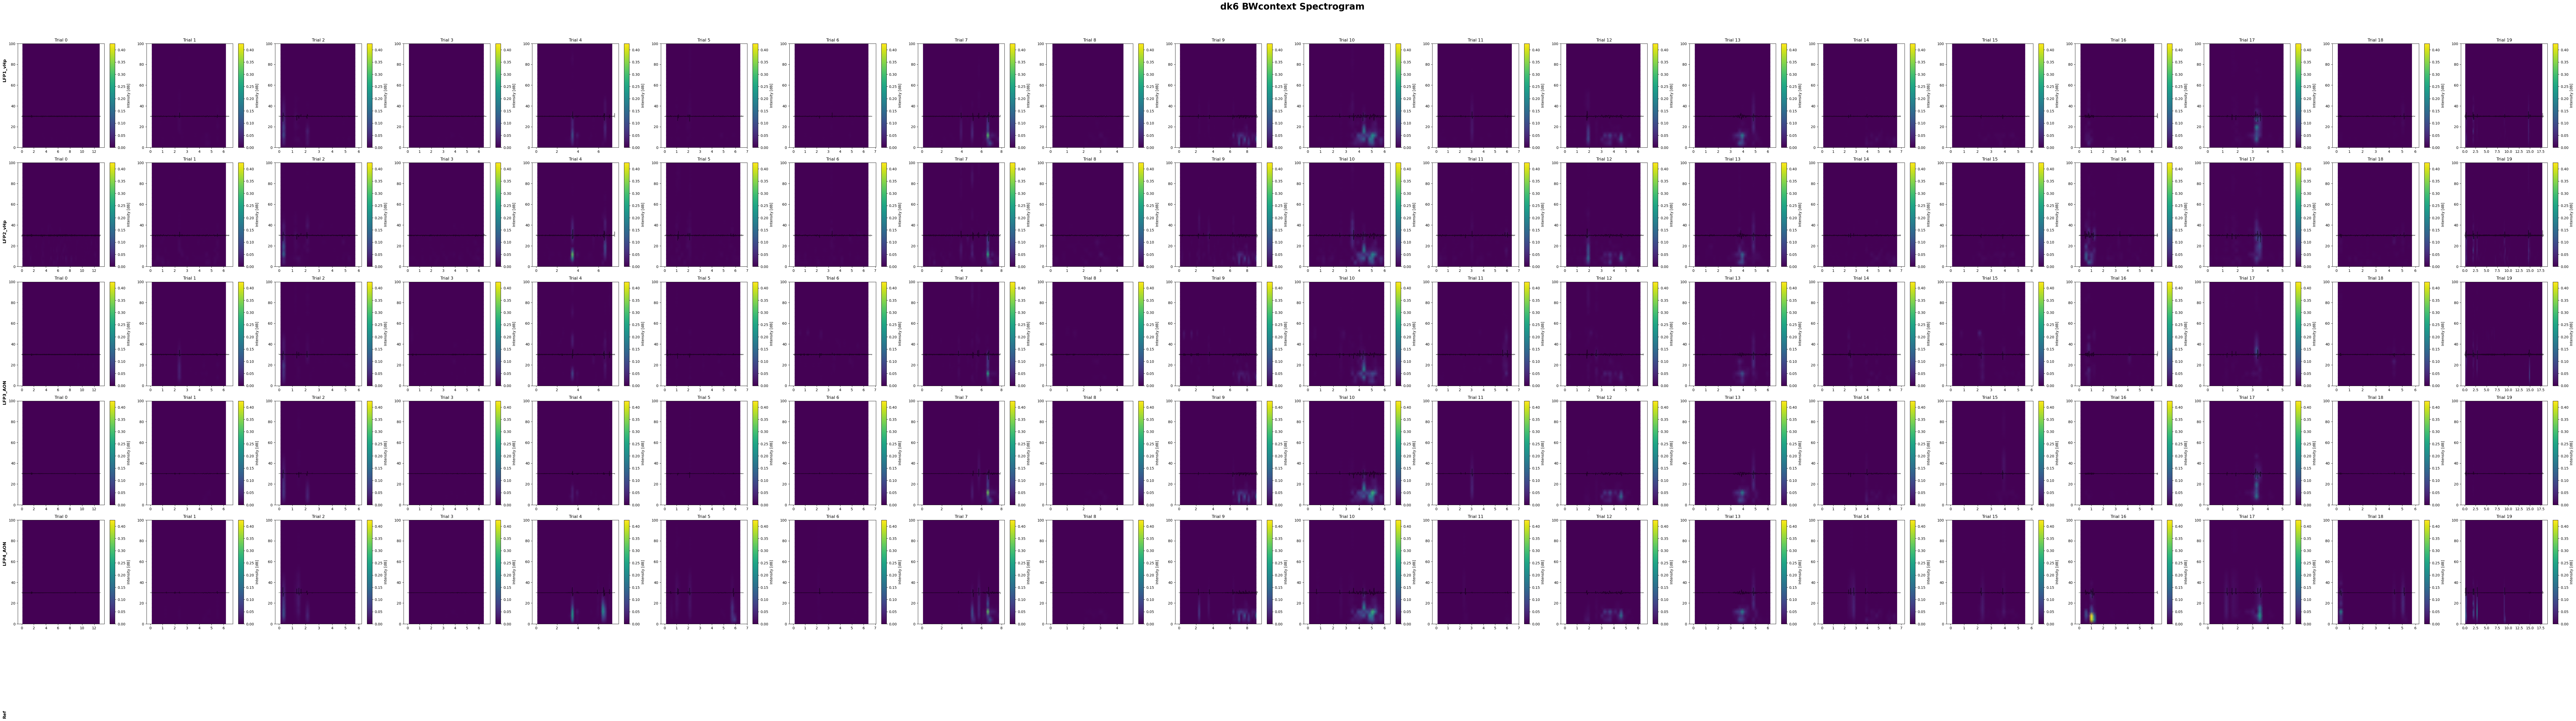

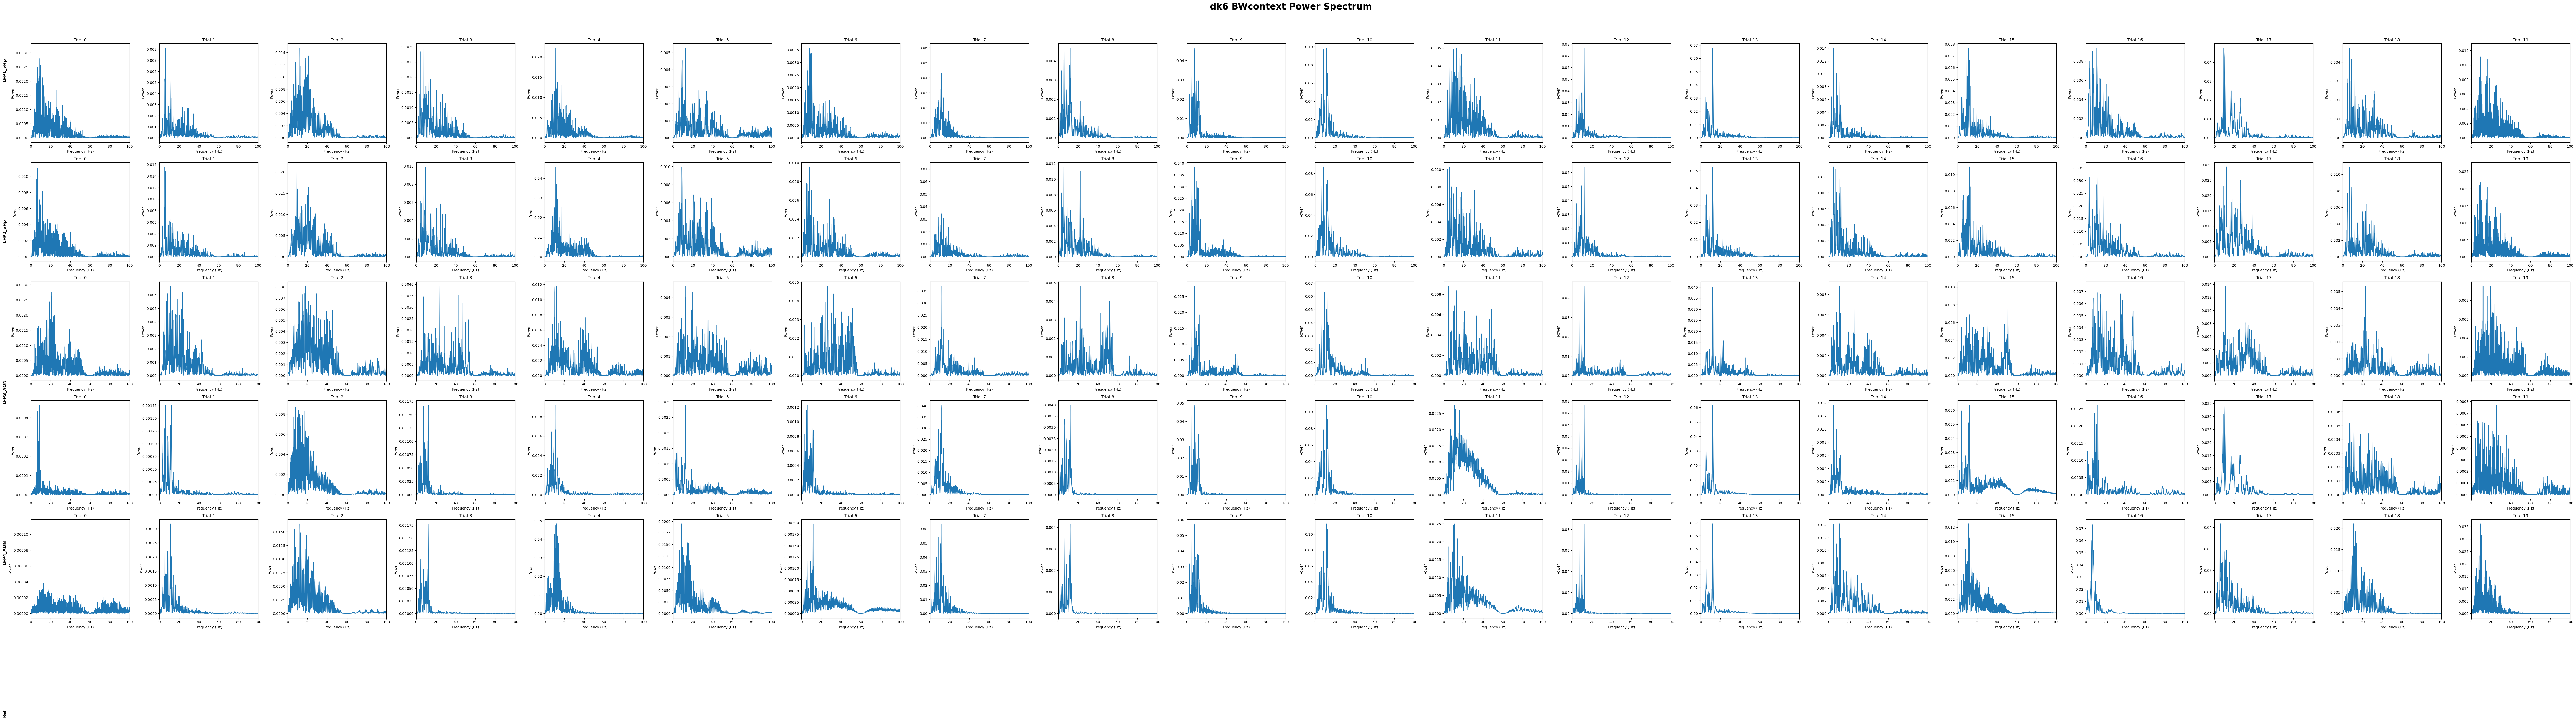

In [ ]:

unique_ids=['dk6_20230615_BWcontext']
import numpy as np
import matplotlib.pyplot as plt
for unique_id in unique_ids:
    experiment_data = compiled_data_all_epochs[compiled_data_all_epochs['unique_id'] == unique_id]
    mouse_id, date, task = unique_id.split('_')
    print(mouse_id, date, task)
    
    channels=np.unique(experiment_data['channel'])
    num_trials = len(np.unique(experiment_data['trial']))

    fig, axs = plt.subplots(len(channels), num_trials, figsize=(5*num_trials, 5*len(channels)))
    fig.suptitle('{} {} Spectrogram'.format(mouse_id, task, date), fontsize=25, fontweight='bold')


    fig2, axs2 = plt.subplots(len(channels), num_trials, figsize=(5*num_trials, 5*len(channels)))
    fig2.suptitle('{} {} Power Spectrum'.format(mouse_id, task, date), fontsize=25, fontweight='bold')



    #channels=['LFP4_AON']
    for channel_idx,channeli in enumerate(channels):
        
        channel_data = experiment_data[experiment_data['channel'] == channeli]
        # Iterate through each trial
        for trial_idx, (i, row) in enumerate(channel_data.iterrows()):
            
                ax = axs[channel_idx, trial_idx]
                
                # Generate the spectrogram
                #Pxx, freqs, bins, im = ax.specgram(row['total_complete_trial'], Fs=2000, cmap="rainbow", NFFT=512, noverlap=256)
                f,t,Sxx= scipy.signal.spectrogram(row['total_complete_trial'], fs=2000, nperseg=512)
                data=row['total_complete_trial']
                time=np.linspace(0, len(data)/2000, len(data))
                im = ax.pcolormesh(t, f, Sxx, shading='gouraud')
                # Plot the raw data
                ax.plot(time, data+30, color='black', alpha=0.5)
                
                # Plot the spectrogram
                ax.set_title(f'Trial {trial_idx}')
                # Add labels in front of each row
                # Plot vertical lines at 2 seconds after the start and 2 seconds before the end
                start_time = bins[0]
                end_time = bins[-1]
                ax.axvline(x=2, color='black', linestyle='--', label='Door opening', ymin=0, ymax=1)
                ax.axvline(x=end_time - 2, color='purple', linestyle='--', label='First Dig', ymin=0, ymax=1)

                # ax.set_xlabel("TIME")
                # ax.set_ylabel("FREQUENCY (Hz)")
                ax.set_ylim(0, 100)
                # # ax.set_yscale('log')
                cbar = fig.colorbar(im, ax=ax)
                cbar.set_label('Intensity [dB]')

                faxis, Sxx = functions.frequency_domain(row['total_complete_trial'], row['time'])
                ax2 = axs2[channel_idx, trial_idx]
                ax2.plot(faxis, Sxx)
                ax2.set_title(f'Trial {trial_idx}')
                ax2.set_xlabel("Frequency (Hz)")
                ax2.set_ylabel("Power")
                ax2.set_xlim(0, 100)
                
                
                # # Plot horizontal bands for theta, beta, and gamma oscillations
                # ax.axhline(y=4, color='blue', linestyle='--', label='Theta (4-8 Hz)')
                # ax.axhline(y=8, color='blue', linestyle='--')
                # ax.axhline(y=12, color='green', linestyle='--', label='Beta (12-30 Hz)')
                # ax.axhline(y=30, color='green', linestyle='--')
                # ax.axhline(y=31, color='red', linestyle='--', label='Gamma (30-100 Hz)')
                # ax.axhline(y=100, color='red', linestyle='--')
        for channel_idx, channeli in enumerate(channels):
            fig.text(0.0, 0.875 - channel_idx * 0.25, channeli, va='center', ha='center', rotation='vertical', fontsize=12, fontweight='bold')

            fig2.text(0.0, 0.875 - channel_idx * 0.25, channeli, va='center', ha='center', rotation='vertical', fontsize=12, fontweight='bold')

        # Add a legend to the last subplot in each row
        # axs[0, -1].legend()
        # axs[1, -1].legend()

        # Adjust layout
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig2.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(os.path.join(savepath,f' {mouse_id} {task} {date} complete trial spectrogram ylim100.png'), dpi=300)
    fig2.savefig(os.path.join(savepath,f' {mouse_id} {task} {date} complete trial power spectrum.png'), dpi=300)
    # Display the plot
    plt.show()

## 4.4 Now we will take a cumulative mean of all the spectrograms for all the trials

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os


channels = np.unique(compiled_data_all_epochs['channel'])

for channeli in channels:
    
    channel_data = compiled_data_all_epochs[compiled_data_all_epochs['channel'] == channeli]
    total_bands = ['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor']

    # Initialize a dictionary to store the spectrogram data
    spectrogram_data = {bandi: {'Pxx': [], 'freqs': None, 'bins': None} for bandi in total_bands}

    # Iterate through each trial and accumulate the spectrogram data
    for trial_idx, (i, row) in enumerate(channel_data.iterrows()):
        for bandi in total_bands:
            Pxx, freqs, bins, im = plt.specgram(row[bandi], Fs=sampling_rate, cmap="rainbow", NFFT=512, noverlap=256)
            spectrogram_data[bandi]['Pxx'].append(Pxx)
            if spectrogram_data[bandi]['freqs'] is None:
                spectrogram_data[bandi]['freqs'] = freqs
            if spectrogram_data[bandi]['bins'] is None:
                spectrogram_data[bandi]['bins'] = bins

    # Compute the mean spectrogram for each band
    mean_spectrogram_data = {bandi: {'Pxx': None, 'freqs': spectrogram_data[bandi]['freqs'], 'bins': spectrogram_data[bandi]['bins']} for bandi in total_bands}
    for bandi in total_bands:
        mean_spectrogram_data[bandi]['Pxx'] = np.mean(spectrogram_data[bandi]['Pxx'], axis=0)

    # Plot the mean spectrogram for each band
    fig, axs = plt.subplots(len(total_bands), 1, figsize=(10, 5*len(total_bands)), sharex=True, sharey=True)
    fig.suptitle('Mean Spectrograms for {}'.format(channeli), fontsize=16, fontweight='bold')

    for band_idx, bandi in enumerate(total_bands):
        ax = axs[band_idx]
        Pxx = mean_spectrogram_data[bandi]['Pxx']
        freqs = mean_spectrogram_data[bandi]['freqs']
        bins = mean_spectrogram_data[bandi]['bins']
        im = ax.pcolormesh(bins, freqs, 10 * np.log10(Pxx), cmap="rainbow")
        
        ax.set_title(f'Mean Spectrogram for {bandi}')
        ax.set_xlabel("TIME")
        ax.set_ylabel("FREQUENCY (Hz)")
        ax.set_ylim(0, 80)
        # ax.set_yscale('log')
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Intensity [dB]')

        # Plot horizontal bands for theta, beta, and gamma oscillations
        ax.axhline(y=4, color='blue', linestyle='--', label='Theta (4-8 Hz)')
        ax.axhline(y=8, color='blue', linestyle='--')
        ax.axhline(y=12, color='green', linestyle='--', label='Beta (12-30 Hz)')
        ax.axhline(y=30, color='green', linestyle='--')
        ax.axhline(y=31, color='red', linestyle='--', label='Gamma (30-100 Hz)')
        ax.axhline(y=100, color='red', linestyle='--')

    # Add a legend to the last subplot
    axs[-1].legend()

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the figure
    fig.savefig(os.path.join(savepath, f'{base_name} {channeli} mean_spectrogram.png'), dpi=300)
    
    # Display the plot
    plt.show()